In [1]:
import pyriemann
from sklearn.model_selection import cross_val_score

## Scripts modified from: https://github.com/pyRiemann/pyRiemann

In [2]:
import mne
from mne.io import read_raw_gdf
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt, sosfiltfilt

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

### Bandpass filter

In [3]:
def butter_lowpass_filter(data, lowcut, fs, order):
    nyq = fs/2
    low = lowcut/nyq
    b, a = butter(order, low, btype='low')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
    return y

def butter_highpass_filter(data, highcut, fs, order):
    nyq = fs/2
    high = highcut/nyq
    b, a = butter(order, high, btype='high')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
    return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = fs/2
    low = lowcut/nyq
    high = highcut/nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = sosfiltfilt(sos, data) # zero-phase filter # data: [ch x time]
    # specify pandlen to make the result the same as Matlab filtfilt()
    return y

### Load EEG

In [153]:
# 769, 770, 774, 780 - left, right, up (tongue), down (feet)
markers = [769, 770, 774, 780]
markers_arr = {769:0, 770:1, 774:2, 780:3}

# for g.tec EEG
nCh = 16
fs = 512
frame = [0.5, 3]
nTime = int((frame[1]-frame[0]) * 512)
nTrial = 10
nClass = len(markers)
bp = [8, 30]

### Training with calibration EEG

In [154]:
train_EEG = np.array([]).reshape(0, nCh, nTime)
train_labels = []
tmp_labels = [[(j+1) for i in range(10)] for j in range(nClass)]
tmp_labels = np.array(tmp_labels)
tmp_labels = np.reshape(tmp_labels, (tmp_labels.shape[0]*tmp_labels.shape[1]))

for i in range(3):
    fname = './data/s01/MI_run%02d.gdf' % (i+1)
    print(fname)
    
    eeg = read_raw_gdf(fname)
    ano_types = eeg.annotations.description.astype(int) # markers
    ano_latency = np.round(eeg.annotations.onset, 4)
    eeg_times = np.round(eeg.times, 4)
    dat = eeg.get_data()

    epoched_EEG = np.zeros((nCh, nTime, nTrial))
    merge_EEG = np.array([]).reshape(nCh, nTime, 0)
    for cur_markers in markers:
        event_indicies = np.argwhere(ano_types == cur_markers)
        event_latencies = ano_latency[event_indicies]
        print('current marker is '+str(cur_markers))
        n_trial = 0
        for cur_latency in event_latencies:
            m_onset = np.where(eeg_times == cur_latency)[0][0]
            tmp_epoch = dat[:, m_onset + int(frame[0]*fs):m_onset + int(frame[1]*fs)]

            # epoch-level bandpass filtering
            tmp_epoch = butter_bandpass_filter(tmp_epoch, bp[0], bp[1], fs, 4)
            epoched_EEG[:, :, n_trial] = tmp_epoch
            n_trial = n_trial + 1
        merge_EEG = np.dstack((merge_EEG, epoched_EEG))
    merge_EEG = np.transpose(merge_EEG, (2, 0, 1)) # now [trial x ch x time]
    
    train_EEG = np.vstack((train_EEG, merge_EEG))
    train_labels = np.append(train_labels, tmp_labels)    
    
cov_train = pyriemann.estimation.Covariances().fit_transform(train_EEG)
print(train_EEG.shape)
print(train_labels.shape)

./data/s01/MI_run01.gdf
Extracting EDF parameters from /Users/kyunghowon/PyRiemann_to_OV/data/s01/MI_run01.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
FP1, FP2, F4, Fz, F3, T7, C3, Cz, C4, T8, P4, Pz, P3, O1, Oz, O2
Creating raw.info structure...


/var/folders/k1/q406tggx1bl9zn8ls0_4pdsc0000gn/T/ipykernel_4658/2385765613.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  eeg = read_raw_gdf(fname)


current marker is 769
current marker is 770
current marker is 774
current marker is 780
./data/s01/MI_run02.gdf
Extracting EDF parameters from /Users/kyunghowon/PyRiemann_to_OV/data/s01/MI_run02.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
FP1, FP2, F4, Fz, F3, T7, C3, Cz, C4, T8, P4, Pz, P3, O1, Oz, O2
Creating raw.info structure...


/var/folders/k1/q406tggx1bl9zn8ls0_4pdsc0000gn/T/ipykernel_4658/2385765613.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  eeg = read_raw_gdf(fname)


current marker is 769
current marker is 770
current marker is 774
current marker is 780
./data/s01/MI_run03.gdf
Extracting EDF parameters from /Users/kyunghowon/PyRiemann_to_OV/data/s01/MI_run03.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
FP1, FP2, F4, Fz, F3, T7, C3, Cz, C4, T8, P4, Pz, P3, O1, Oz, O2
Creating raw.info structure...


/var/folders/k1/q406tggx1bl9zn8ls0_4pdsc0000gn/T/ipykernel_4658/2385765613.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  eeg = read_raw_gdf(fname)


current marker is 769
current marker is 770
current marker is 774
current marker is 780
(120, 16, 1280)
(120,)


### Evaluating performance with test EEG

In [155]:
test_EEG = np.array([]).reshape(0, nCh, nTime)
test_labels = []
tmp_labels = [[(j+1) for i in range(10)] for j in range(nClass)]
tmp_labels = np.array(tmp_labels)
tmp_labels = np.reshape(tmp_labels, (tmp_labels.shape[0]*tmp_labels.shape[1]))

for i in range(3,6):
    fname = './data/s01/MI_run%02d.gdf' % (i+1)
    print(fname)
    
    eeg = read_raw_gdf(fname)
    ano_types = eeg.annotations.description.astype(int) # markers
    ano_latency = np.round(eeg.annotations.onset, 4)
    eeg_times = np.round(eeg.times, 4)
    dat = eeg.get_data()

    epoched_EEG = np.zeros((nCh, nTime, nTrial))
    merge_EEG = np.array([]).reshape(nCh, nTime, 0)
    for cur_markers in markers:
        event_indicies = np.argwhere(ano_types == cur_markers)
        event_latencies = ano_latency[event_indicies]
        print('current marker is '+str(cur_markers))
        n_trial = 0
        for cur_latency in event_latencies:
            m_onset = np.where(eeg_times == cur_latency)[0][0]
            tmp_epoch = dat[:, m_onset + int(frame[0]*fs):m_onset + int(frame[1]*fs)]

            # epoch-level bandpass filtering
            tmp_epoch = butter_bandpass_filter(tmp_epoch, bp[0], bp[1], fs, 4)
            epoched_EEG[:, :, n_trial] = tmp_epoch
            n_trial = n_trial + 1
        merge_EEG = np.dstack((merge_EEG, epoched_EEG))
    merge_EEG = np.transpose(merge_EEG, (2, 0, 1)) # now [trial x ch x time]
    
    test_EEG = np.vstack((test_EEG, merge_EEG))
    test_labels = np.append(test_labels, tmp_labels)    
    
    
cov_test = pyriemann.estimation.Covariances().fit_transform(test_EEG)
print(test_EEG.shape)
print(test_labels.shape)

./data/s01/MI_run04.gdf
Extracting EDF parameters from /Users/kyunghowon/PyRiemann_to_OV/data/s01/MI_run04.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
FP1, FP2, F4, Fz, F3, T7, C3, Cz, C4, T8, P4, Pz, P3, O1, Oz, O2
Creating raw.info structure...


/var/folders/k1/q406tggx1bl9zn8ls0_4pdsc0000gn/T/ipykernel_4658/2046320893.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  eeg = read_raw_gdf(fname)


current marker is 769
current marker is 770
current marker is 774
current marker is 780
./data/s01/MI_run05.gdf
Extracting EDF parameters from /Users/kyunghowon/PyRiemann_to_OV/data/s01/MI_run05.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
FP1, FP2, F4, Fz, F3, T7, C3, Cz, C4, T8, P4, Pz, P3, O1, Oz, O2
Creating raw.info structure...


/var/folders/k1/q406tggx1bl9zn8ls0_4pdsc0000gn/T/ipykernel_4658/2046320893.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  eeg = read_raw_gdf(fname)


current marker is 769
current marker is 770
current marker is 774
current marker is 780
./data/s01/MI_run06.gdf
Extracting EDF parameters from /Users/kyunghowon/PyRiemann_to_OV/data/s01/MI_run06.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
FP1, FP2, F4, Fz, F3, T7, C3, Cz, C4, T8, P4, Pz, P3, O1, Oz, O2
Creating raw.info structure...


/var/folders/k1/q406tggx1bl9zn8ls0_4pdsc0000gn/T/ipykernel_4658/2046320893.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  eeg = read_raw_gdf(fname)


current marker is 769
current marker is 770
current marker is 774
current marker is 780
(120, 16, 1280)
(120,)


In [171]:
mdm = pyriemann.classification.MDM()
mdm.metric = 'Riemann'
mdm.fit(cov_train, train_labels) # training

mdm_train_acc = np.sum(mdm.predict(cov_train) == train_labels) / len(train_labels) # train - meaningless
print('training accuracy is', np.round(mdm_train_acc,4))

mdm_acc = np.sum(mdm.predict(cov_test) == test_labels) / len(test_labels) # test
print('test accuracy is',np.round(mdm_acc,4))

training accuracy is 0.7917
test accuracy is 0.625


In [161]:
import sklearn
import seaborn as sns

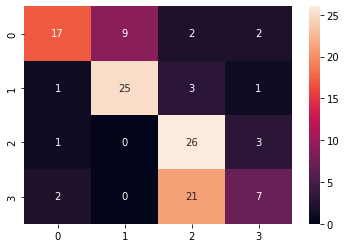

In [164]:
confusion_mdm = sklearn.metrics.confusion_matrix(test_labels, mdm.predict(cov_test)) # y_true, y_pred
ax = sns.heatmap(confusion_mdm, annot=True, fmt="d")

### References

[1] A. Barachant, M. Congedo ,"A Plug&Play P300 BCI Using Information Geometry", arXiv:1409.0107. link

[2] M. Congedo, A. Barachant, A. Andreev ,"A New generation of Brain-Computer Interface Based on Riemannian Geometry", arXiv: 1310.8115. link

[3] A. Barachant and S. Bonnet, "Channel selection procedure using riemannian distance for BCI applications," in 2011 5th International IEEE/EMBS Conference on Neural Engineering (NER), 2011, 348-351. pdf

[4] A. Barachant, S. Bonnet, M. Congedo and C. Jutten, "Multiclass Brain-Computer Interface Classification by Riemannian Geometry," in IEEE Transactions on Biomedical Engineering, vol. 59, no. 4, p. 920-928, 2012. pdf

[5] A. Barachant, S. Bonnet, M. Congedo and C. Jutten, "Classification of covariance matrices using a Riemannian-based kernel for BCI applications", in NeuroComputing, vol. 112, p. 172-178, 2013. pdf